In [2]:
%load_ext autoreload
%autoreload 2
import netCDF4
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants, split_participants, split_participants_into_folds
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test, calculate_global_class_weights, EarlyStopper, test_shuffled
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset, MultiXArrayDataset, MultiXArrayProbaDataset
from hmpai.data import SAT1_STAGES_ACCURACY, SAT_CLASSES_ACCURACY
from hmpai.visualization import plot_confusion_matrix
from hmpai.pytorch.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from hmpai.pytorch.transforms import *
from collections import defaultdict
from hmpai.pytorch.mamba import *
import os
from copy import deepcopy
import json
from hmpai.pytorch.utilities import save_tensor
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

from ray import train as ray_train, tune
from ray.tune.schedulers import ASHAScheduler
from ray.train import Checkpoint
import tempfile
from ray.tune.tune_config import TuneConfig
from ray.train import ScalingConfig, RunConfig

DATA_PATH = Path(os.getenv("DATA_PATH"))
labels = SAT_CLASSES_ACCURACY


#### Visualization

In [8]:
path = Path("/logs/transformation_tuning")
result_files = list(path.glob("*/*/result.json"))

dicts = []
for file in result_files:
    with open(file, 'r') as f:
        lines = f.readlines()[-1]
        data = json.loads(lines)

    data_dict = {f'diff_{i}': diff for i, diff in enumerate(data['diff'])}
    data_dict['val_loss'] = data['val_loss']
    data_dict.update({f"transformation_{i}": prob for i, prob in enumerate(data['config'].values())})
    df = pd.DataFrame([data_dict])
    dicts.append(df)
data = pd.concat(dicts)

In [10]:
data = data[data['val_loss'] != 999]

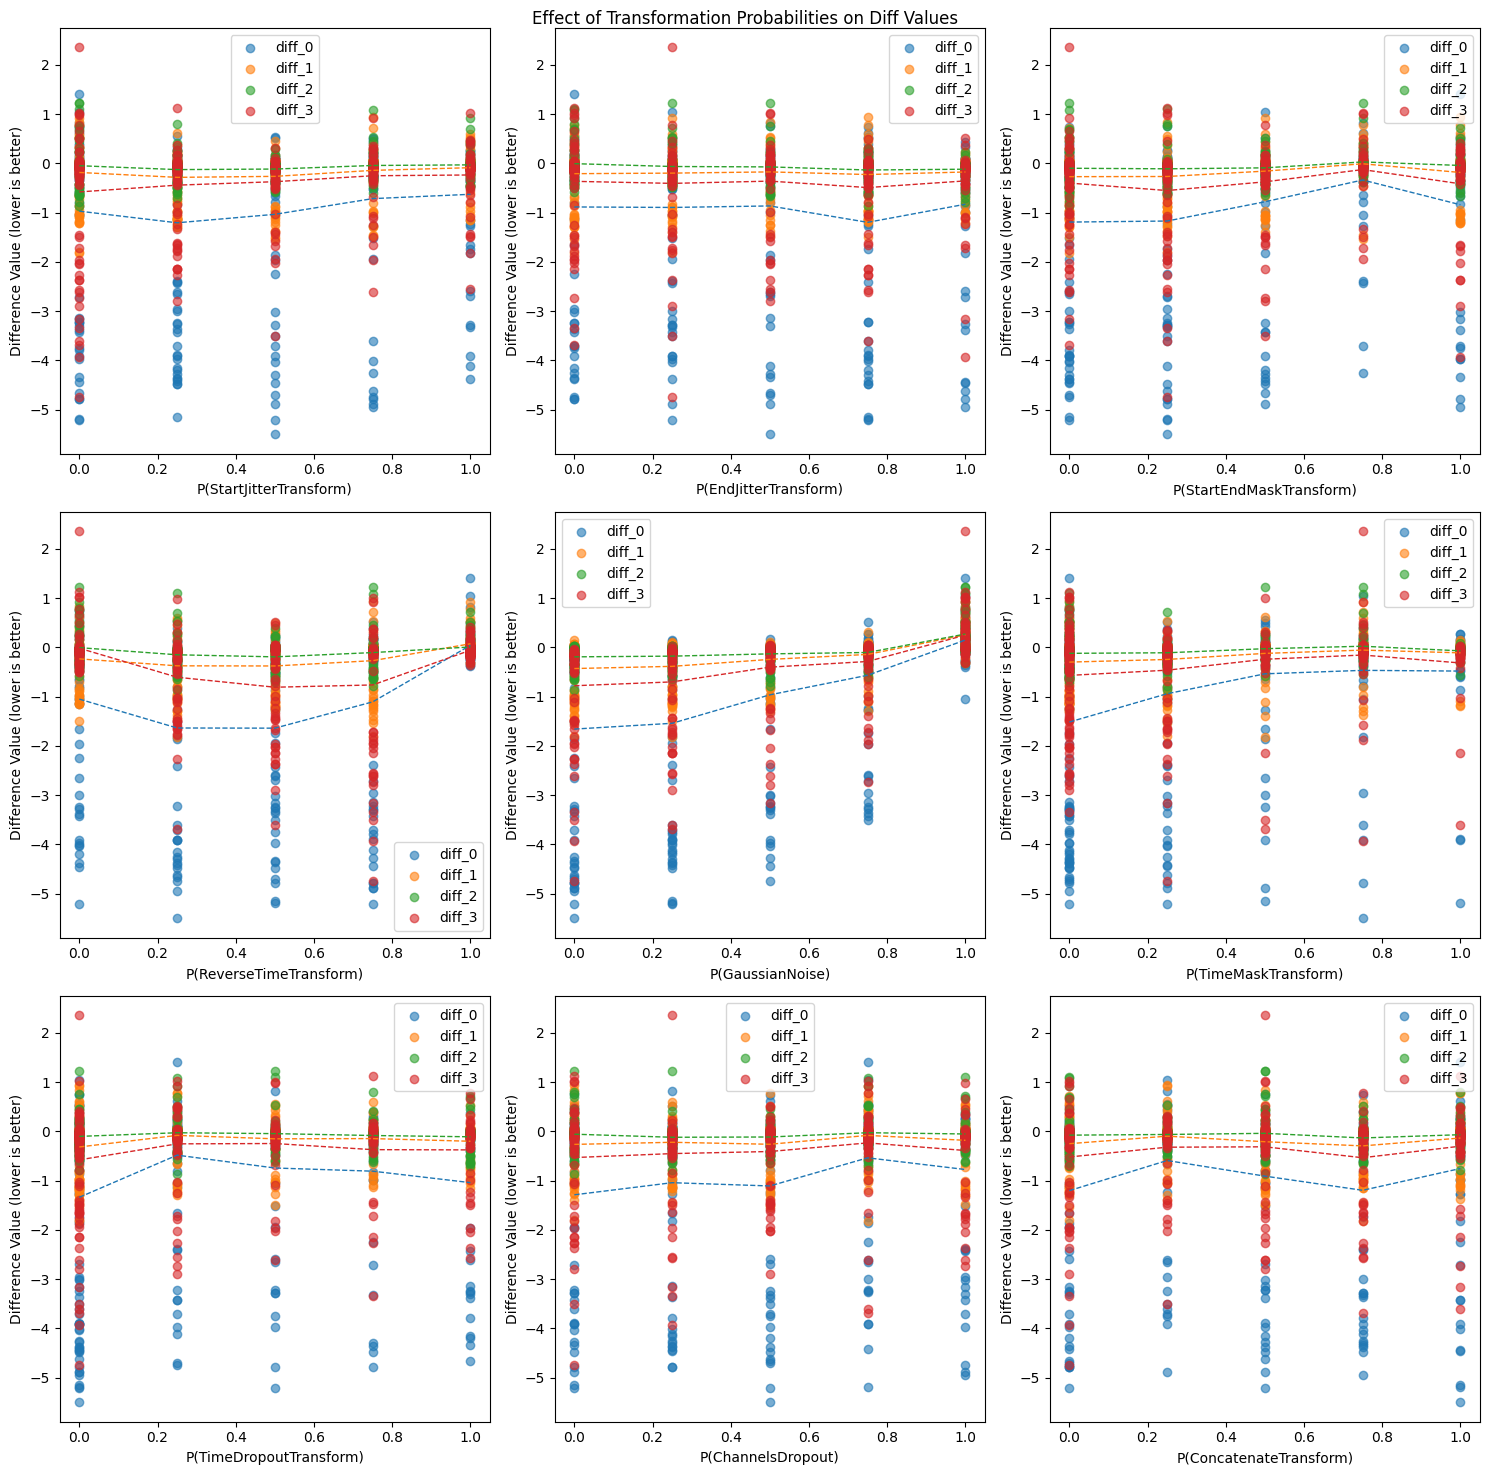

In [12]:
transforms = [
    StartJitterTransform(62, 0),
    EndJitterTransform(63, 0.0),
    StartEndMaskTransform(probability=0.0),
    ReverseTimeTransform(probability=0.0),
    GaussianNoise(probability=0.0),
    TimeMaskTransform(probability=0.0),
    TimeDropoutTransform(probability=0.0),
    ChannelsDropout(probability=0.0),
    ConcatenateTransform(concat_probability=0.0),
]

# Plot the effect of each transformation probability on each diff value
fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # Adjust the grid size based on the number of transformations
fig.suptitle('Effect of Transformation Probabilities on Diff Values')

for i in range(9):  # Assuming you have 9 transformations
    ax = axs[i // 3, i % 3]
    for i_diff, diff_col in enumerate(['diff_0', 'diff_1', 'diff_2', 'diff_3']):
        ax.scatter(data[f'transformation_{i}'], data[diff_col], label=diff_col, alpha=0.6)
        mean_diff_per_transformation = data.groupby(f'transformation_{i}')[diff_col].mean()
        ax.plot(mean_diff_per_transformation.index, mean_diff_per_transformation.values, linestyle='--', linewidth=1)
    ax.set_xlabel(f'P({transforms[i].__class__.__name__})')
    ax.set_ylabel('Difference Value (lower is better)')
    ax.legend()
plt.tight_layout()
plt.show()

In [13]:
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

# Example data preparation
X = data[[f'transformation_{i}' for i in range(9)]]  # Independent variables (transformations)
name_mapping = {f'transformation_{i}': tf.__class__.__name__ for i, tf in enumerate(transforms)}
X = X.rename(name_mapping, axis=1)

# Create polynomial features including interaction terms (degree=2 includes interactions but no higher powers)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = pd.DataFrame(poly.fit_transform(X), columns=poly.get_feature_names_out(X.columns))

X_poly.reset_index(drop=True, inplace=True)
data.reset_index(drop=True, inplace=True)
for diff_col in ['diff_0', 'diff_1', 'diff_2', 'diff_3']:
    y = data[diff_col]  # Dependent variable (e.g., diff_0)

    # Add a constant term for the intercept
    X_poly_with_const = sm.add_constant(X_poly)

    # Fit the regression model
    model = sm.OLS(y, X_poly_with_const).fit()

    # Print the summary
    print(f"Summary for {diff_col}:")
    print(model.summary())


Summary for diff_0:
                            OLS Regression Results                            
Dep. Variable:                 diff_0   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     7.262
Date:                Thu, 10 Oct 2024   Prob (F-statistic):           2.87e-27
Time:                        08:53:21   Log-Likelihood:                -508.76
No. Observations:                 334   AIC:                             1110.
Df Residuals:                     288   BIC:                             1285.
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

#### Run tuner

In [3]:
set_global_seed(42)
data_path_1 = DATA_PATH / "sat2/stage_data_proba_250hz_part1.nc"
data_path_2 = DATA_PATH / "sat2/stage_data_proba_250hz_part2.nc"
data_paths = [data_path_1, data_path_2]
# train_percentage=100 makes test and val 100 as well
splits = split_participants(data_paths, train_percentage=60)
labels = SAT_CLASSES_ACCURACY
info_to_keep = []
whole_epoch = True
subset_cond = "accuracy"
batch_size = 64
add_negative = True

In [4]:
def base_mamba():
    embed_dim = 64
    out_channels = 128
    base_cnn = nn.Sequential(
        nn.Conv1d(
            in_channels=embed_dim,
            out_channels=out_channels,
            kernel_size=50,
            stride=1,
            padding="same",
        ),
        nn.ReLU(),
    )
    model_kwargs = {
        "embed_dim": embed_dim,
        "mamba_dim": out_channels,
        "n_channels": 19,
        "n_classes": len(labels),
        "n_mamba_layers": 5,
        "cnn_module": base_cnn,
        "dropout": 0.1,
    }
    model = ConfigurableMamba(**model_kwargs)
    return model

In [5]:
norm_fn = norm_mad_zscore
train_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[0],
    normalization_fn=norm_fn,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    add_negative=add_negative,
)
norm_vars = get_norm_vars_from_global_statistics(train_data.statistics, norm_fn)
class_weights = train_data.statistics["class_weights"]
test_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[1],
    normalization_fn=norm_fn,
    norm_vars=norm_vars,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    add_negative=add_negative,
)
val_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[2],
    normalization_fn=norm_fn,
    norm_vars=norm_vars,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    add_negative=add_negative,
)

In [6]:
def tune_transformation(config):
    train_data.set_transform(
        Compose(
            [
                StartJitterTransform(62, config["transformation_0"]),
                EndJitterTransform(63, config["transformation_1"]),
                StartEndMaskTransform(probability=config["transformation_2"]),
                ReverseTimeTransform(probability=config["transformation_3"]),
                GaussianNoise(probability=config["transformation_4"]),
                TimeMaskTransform(probability=config["transformation_5"]),
                TimeDropoutTransform(probability=config["transformation_6"]),
                ChannelsDropout(probability=config["transformation_7"]),
                ConcatenateTransform(concat_probability=config["transformation_8"]),
            ]
        )
    )
    train_loader = DataLoader(
        train_data, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True
    )
    val_loader = DataLoader(
        val_data, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True
    )
    test_loader = DataLoader(
        test_data, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True
    )

    model = base_mamba()
    model = model.to(DEVICE)

    loss_fn = torch.nn.KLDivLoss(reduction="batchmean", log_target=False)

    opt = torch.optim.NAdam(model.parameters(), weight_decay=0, lr=0.0005)

    stopper = EarlyStopper()

    # Epochs
    lowest_val_loss = 10000000
    temp_checkpoint_dir = tempfile.mkdtemp()
    checkpoint_file_dir = os.path.join(temp_checkpoint_dir, "model.pt")
    for i in range(20):
        batch_losses = train(model, train_loader, opt, loss_fn, whole_epoch=True)
        loss = np.mean(batch_losses)

        val_losses, val_accuracy = validate(
            model, val_loader, loss_fn, whole_epoch=True
        )
        val_loss = np.mean(val_losses)
        ray_train.report({"val_loss": val_loss, "epoch": i})

        # print(i, val_loss)
        if val_loss < lowest_val_loss:
            # Save model checkpoint
            torch.save(
                model.state_dict(), checkpoint_file_dir
            )
            lowest_val_loss = val_loss

        if stopper.check_stop(val_loss):
            break
    if os.path.exists(checkpoint_file_dir):
        model.load_state_dict(
            torch.load(os.path.join(checkpoint_file_dir))
        )
    else:
        ray_train.report({"diff": [999, 999, 999, 999], "val_loss": 999, "epoch": i})
        return

    result, _, _ = test_shuffled(
        model, test_loader, loss_fn, None, whole_epoch=True
    )
    diff = result[0]["metric_pred"] - result[0]["metric_shuffled"]
    diff = diff.mean(dim=0)

    ray_train.report({"diff": diff.tolist(), "val_loss": lowest_val_loss, "mean_diff": diff.mean().item(), "epoch": i})

In [25]:
import numpy as np
# search_space = {
#     f"transformation_{i}": np.random.choice([0, 0.25, 0.50, 0.75, 1.0]) for i in range(9)
# }
search_space = {
    f"transformation_{i}": np.random.choice([1.0]) for i in range(9)
}
tune_transformation(search_space)

In [7]:
torch.cuda.empty_cache()
search_space = {
    f"transformation_{i}": tune.choice([0, 0.25, 0.50, 0.75, 1.0]) for i in range(9)
}

tuner = tune.Tuner(
    tune.with_resources(
        tune.with_parameters(tune_transformation), resources={"cpu": 12, "gpu": 1}
    ),
    run_config=RunConfig(
        name='transformation',
        storage_path='/logs/transformation_tuning',
    ),
    tune_config=tune.TuneConfig(
        metric=None,
        mode=None,
        # scheduler=scheduler,
        num_samples=1000,
    ),
    param_space=search_space,
)

results = tuner.fit()

(tune_transformation pid=1384596) /opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
(tune_transformation pid=1384596)   return F.conv1d(input, weight, bias, self.stride,
(tune_transformation pid=1388267) /opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
(tune_transformation pid=1388267)   return F.conv1d(input, weight, bias, self.stride,
(tune_transformation pid=1388770) /opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of 